In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def curvas(caminho):
    url = caminho

    cabecalho = ['PROF','GR', 'RHOB', 'NPHI']
    data_DP1 = pd.read_csv(url, usecols=(0,5,8,9), header=42, sep='\s+', names=cabecalho)

    #______________________________________________________________________________#
    # Remover valores nulos -999.000

    DP1 = data_DP1.loc[(data_DP1['GR'] != -999.00000) & 
                      (data_DP1['RHOB']  != -999.00000) &
                      (data_DP1['NPHI']  != -999.00000)]

    ##############################
    prof_DP1 = np.copy(DP1['PROF'])
    GR_DP1 = np.copy(DP1['GR'])
    RHOB_DP1 = np.copy(DP1['RHOB'])
    NPHI_DP1 = np.copy(DP1['NPHI'])
    ##############################

    #______________________________________________________________________________#

    ### calculando o VSH para as duas curvas:

    rho_ma = 2.65 # densidade da matriz
    rho_fl = 1.10 # densidade do fluído
    rho_sh = 2.70 # densidade do folhelho

    ##############################
    VSH_GR_DP1   = [] # argilosidade via perfil de raios gama
    VSH_ND_DP1   = [] # argilosidade via perfis NPHI e DPHI
    VSH_ND_DP1_0 = [] # argilosidade NPHI e DPHI normalizada
    ##############################
    min_GR_DP1 = min(GR_DP1) # valor mínimo da argilosidade no perfil de raios-gama (GR)
    max_GR_DP1 = max(GR_DP1) # valor máximo da argilosidade no perfil de raios-gama (GR)
    ##############################

    for i in range (len(prof_DP1)):
        IGR0 = (GR_DP1[i] - min_GR_DP1)/(max_GR_DP1 - min_GR_DP1) # Calculo da Argilosidade (basica, Schlumberger)
        
        vsh_gr = 0.083*((2**(3.70*IGR0))-1)        # Correcao de Larionov para Argilosidade
        VSH_GR_DP1.append(vsh_gr)

        #_____________________________________________________#

        phi_ed = ((((RHOB_DP1[i] - rho_ma)/(rho_fl - rho_ma)) - 
                     ((vsh_gr)*(rho_sh - rho_ma)/(rho_fl - rho_ma))))
        VSH_ND_DP1_0.append(NPHI_DP1[i] - phi_ed) # calculo da argilosidade pela diferenca entre NPHI e DPHI
        
    ##############################
    # n de normalizada
    
    min_GR_DP1_n = min(VSH_ND_DP1_0) 
    max_GR_DP1_n = max(VSH_ND_DP1_0)

    ##############################

    for i in range (len(prof_DP1)):
        VSH_ND_DP1.append((VSH_ND_DP1_0[i] - min_GR_DP1_n)/(max_GR_DP1_n - min_GR_DP1_n))

    #---------------------------------------------------------------------------------#
    ### Graficos

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4) # 4 cruvas = 4 subplots
    fig.set_size_inches(12, 11) # tamanho da figura | polegadas

    #_____________________________________________________#

    ax1.plot(GR_DP1,prof_DP1,'-g',linewidth = 1,label='GR')
    # (eixo x, eixo y, cor e tipo, comprimento da curva, legenda )
    ax1.invert_yaxis()
    # inverte o eixo y
    ax1.grid()
    # adiciona o 'grid' ou malha de fundo
    ax1.set_ylabel('profundidade ($m$)', fontsize=16)
    # o que vai ser escrito no eixo y
    ax1.set_title('GR', fontsize=16)
    # titulo do 'track' ou do grafico com tamanho de letra 16

    #_____________________________________________________#

    ax2.plot(RHOB_DP1,prof_DP1,'-b',linewidth = 1,label='RHOB')
    ax2.invert_yaxis()
    ax2.grid()
    ax2.set_yticklabels([]) # remove as profundidades do eixo y
    ax2.set_title('RHOB', fontsize=16)
    ax2.set_xlim(2,3)

    #_____________________________________________________#

    ax3.plot(NPHI_DP1,prof_DP1,'-k',linewidth = 1,label='NPHI')
    ax3.invert_yaxis()
    ax3.grid()
    ax3.set_yticklabels([])
    ax3.set_title('NPHI', fontsize=16)
    ax3.set_xlim(45,-15)

    #_____________________________________________________#

    ax4.plot(VSH_GR_DP1,prof_DP1,'-g',linewidth = 1,label='VSH_GR')
    ax4.plot(VSH_ND_DP1,prof_DP1,'-b',linewidth = 1,label='VSH_ND')
    ax4.invert_yaxis()
    ax4.grid()
    ax4.set_yticklabels([])
    ax4.set_title('VSH', fontsize=16)
    # adiciona a posicao da legenda
    ax4.legend(loc=2)

    plt.show()
    #---------------------------------------------------------------------------------#
    return (prof_DP1,VSH_GR_DP1,VSH_ND_DP1)

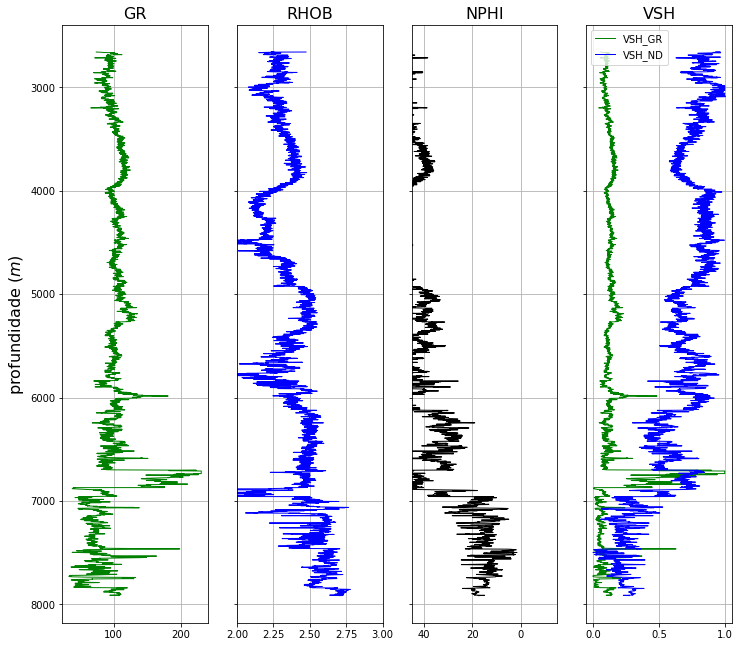

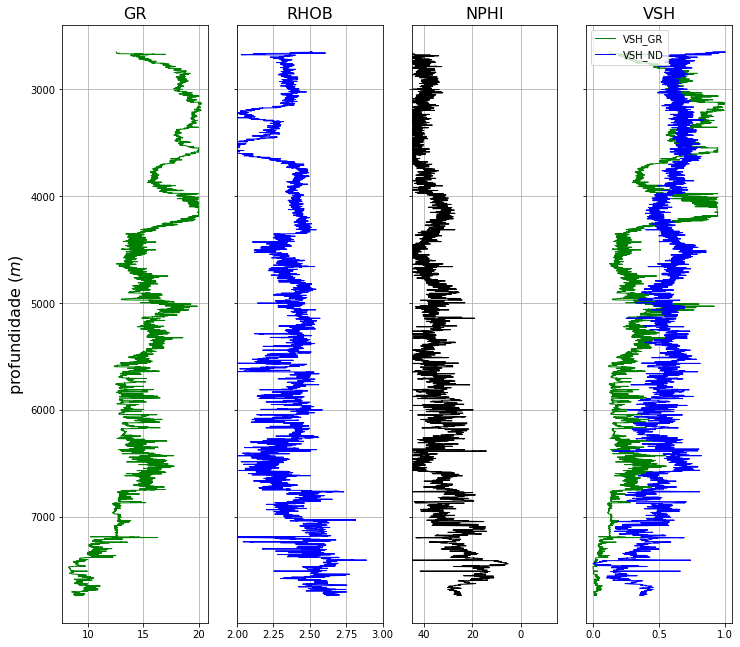

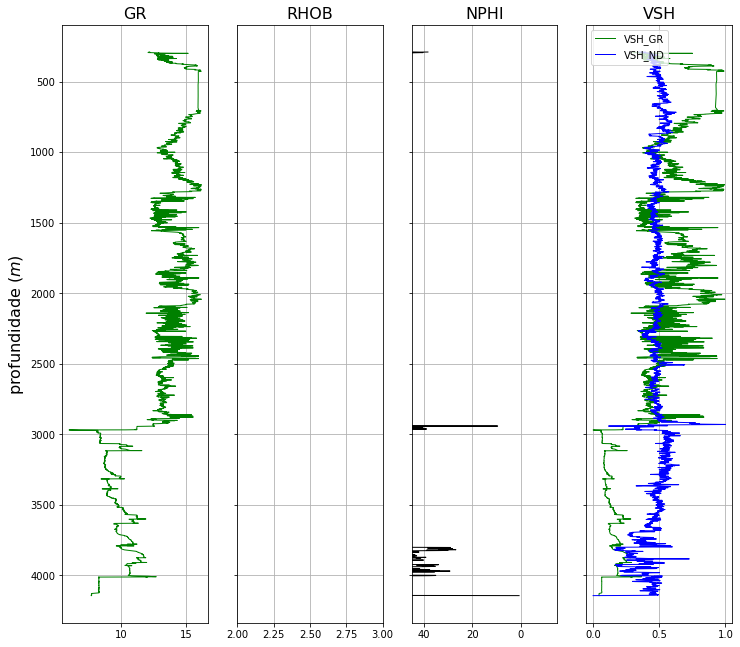

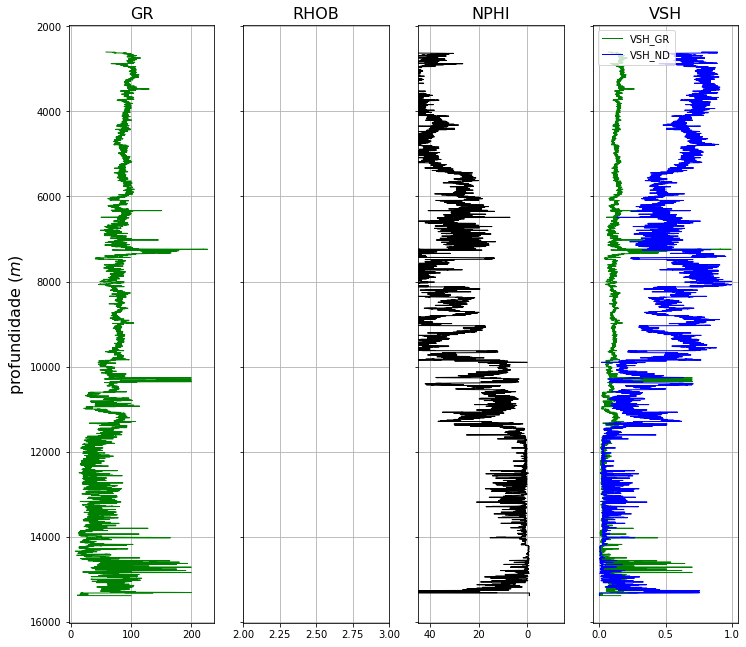

In [7]:
### Preparando os dados para o aprendizado de maquina:

data_DP1 = curvas('dados/DP1.LAS')
data_ES1 = curvas('dados/ES1.LAS')
data_WD1 = curvas('dados/WD1.LAS')
data_IK1 = curvas('dados/IK1.LAS')

VSH_GR = data_DP1[1] + data_ES1[1] + data_IK1[1] + data_WD1[1] # transformando as curvas de VSH em uma so
VSH_ND = data_DP1[2] + data_ES1[2] + data_IK1[2] + data_WD1[2]

LITO = []

for i in range(len(VSH_ND)):
    if VSH_ND[i] > 0.5:
        LITO.append(57)
    else:
        LITO.append(49)

In [10]:
from sklearn.linear_model import Perceptron

MEGA_DATA = [VSH_GR,VSH_ND]

MEGA_DATA = np.array(MEGA_DATA)

DP1_DATA = np.array([data_DP1[1],data_DP1[2]])

d = Perceptron()

e = d.fit(MEGA_DATA.T,LITO)

f = d.predict(DP1_DATA.T)

In [11]:
print(f)

[57 57 57 ... 49 49 49]
